<a href="https://colab.research.google.com/github/mayanjabbaale/GANs/blob/main/Basic_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import torch.nn as nn
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

In [25]:
class Discriminator(nn.Module):
  def __init__(self, img_dim):
    super().__init__()
    self.dim = nn.Sequential(
        nn.Linear(img_dim, 128),
        nn.LeakyReLU(0.1),
        nn.Linear(128, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.dim(x)

class Generator(nn.Module):
  def __init__(self, z_dim, img_dim):
    super().__init__()
    self.gen = nn.Sequential(
        nn.Linear(z_dim, 256),
        nn.LeakyReLU(0.1),
        nn.Linear(256, img_dim),
        nn.Tanh()
    )

  def forward(self, x):
    return self.gen(x)


device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 100
img_dim = 28 * 28 * 1
batch_size = 32
num_epochs = 50

disc = Discriminator(img_dim=img_dim).to(device)
gen = Generator(z_dim=z_dim, img_dim=img_dim).to(device)

fixed_noise = torch.randn((batch_size, z_dim))
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root="MNIST", transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
optim_gen = torch.optim.Adam(gen.parameters(), lr=lr)
optim_disc = torch.optim.Adam(disc.parameters(), lr=lr)
loss_fn = torch.nn.BCELoss()

for epoch in range(num_epochs):
  for real_img, _ in dataloader:
    real_img = real_img.view(-1, 784).to(device)
    batch_size = real_img.shape[0]

    #train discriminator
    noise = torch.randn(batch_size, z_dim).to(device)
    fake = gen(noise)
    disc_real = disc(real_img).view(-1)
    disc_fake = disc(fake).view(-1)
    lossD_real = loss_fn(disc_real, torch.ones_like(disc_real))
    lossD_fake = loss_fn(disc_fake, torch.zeros_like(disc_fake))
    d_loss = (lossD_real + lossD_fake) / 2
    disc.zero_grad()
    d_loss.backward(retain_graph=True)
    optim_disc.step()

    #train generator
    output = disc(fake).view(-1)
    lossG = loss_fn(output, torch.ones_like(output))
    optim_gen.zero_grad()
    lossG.backward()
    optim_gen.step()

  print(
      f'Epoch [{epoch}/{num_epochs}] Loss D: {d_loss:4f}, Loss G: {lossG:.4f}'
  )

Epoch [0/50] Loss D: 0.435569, Loss G: 1.4384
Epoch [1/50] Loss D: 0.497954, Loss G: 1.4201
Epoch [2/50] Loss D: 0.677046, Loss G: 1.0313
Epoch [3/50] Loss D: 0.513742, Loss G: 0.9770
Epoch [4/50] Loss D: 0.692467, Loss G: 0.8616
Epoch [5/50] Loss D: 0.674193, Loss G: 0.9097
Epoch [6/50] Loss D: 0.538253, Loss G: 0.9570
Epoch [7/50] Loss D: 0.618956, Loss G: 0.8431
Epoch [8/50] Loss D: 0.494024, Loss G: 1.0897
Epoch [9/50] Loss D: 0.744924, Loss G: 0.8682
Epoch [10/50] Loss D: 0.687425, Loss G: 1.0309
Epoch [11/50] Loss D: 0.546470, Loss G: 1.1639
Epoch [12/50] Loss D: 0.661153, Loss G: 0.9014
Epoch [13/50] Loss D: 0.438958, Loss G: 1.3735
Epoch [14/50] Loss D: 0.611991, Loss G: 1.0613
Epoch [15/50] Loss D: 0.804943, Loss G: 0.7203
Epoch [16/50] Loss D: 0.500810, Loss G: 1.3692
Epoch [17/50] Loss D: 0.680136, Loss G: 1.1597
Epoch [18/50] Loss D: 0.673635, Loss G: 1.3841
Epoch [19/50] Loss D: 0.439130, Loss G: 1.0974
Epoch [20/50] Loss D: 0.556503, Loss G: 1.2044
Epoch [21/50] Loss D: 0

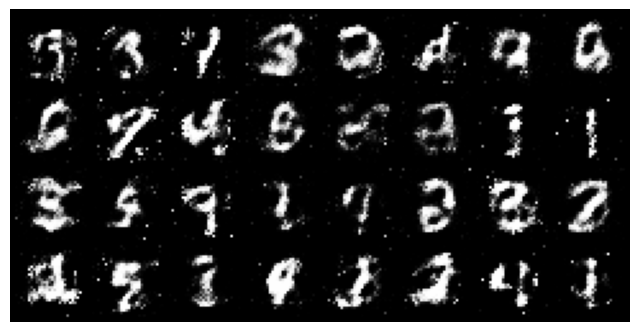

In [26]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

with torch.no_grad():
    fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
    fake = (fake + 1) / 2

grid = vutils.make_grid(fake, nrow=8)

plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.axis("off")
plt.show()